In [ ]:
# # Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Put Colab in the context of this challenge
# import os

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('/content/drive/MyDrive/Colab Notebooks/sign-language-interpretation')

In [1]:
import matplotlib.pyplot as plotter_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
%matplotlib inline
import os
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageOps

2023-05-24 18:33:00.069726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 18:33:00.752081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 18:33:00.756431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 18:33:04.943244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
root_directory = "raw_data/asl_alphabet_train"  # Replace with the root directory path
image_paths = []
last_subdirectory_names = []
letters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13,
            'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,
            'space':26, 'del':27, 'nothing':28}

# Traverse the directory tree
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):  # Modify the extensions if necessary
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
            last_subdirectory = os.path.basename(os.path.dirname(image_path))
            last_subdirectory_names.append(str(letters[last_subdirectory]))
# Create a DataFrame from the collected data
image_map = {
    'Image_Path': image_paths,
    'Label': last_subdirectory_names}

df = pd.DataFrame(image_map)
# Print the DataFrame
print(df)


                                    Image_Path Label
0      raw_data/asl_alphabet_train/J/J2014.jpg     9
1      raw_data/asl_alphabet_train/J/J2324.jpg     9
2      raw_data/asl_alphabet_train/J/J2452.jpg     9
3      raw_data/asl_alphabet_train/J/J1837.jpg     9
4       raw_data/asl_alphabet_train/J/J838.jpg     9
...                                        ...   ...
86995  raw_data/asl_alphabet_train/Z/Z2601.jpg    25
86996  raw_data/asl_alphabet_train/Z/Z2016.jpg    25
86997  raw_data/asl_alphabet_train/Z/Z1253.jpg    25
86998  raw_data/asl_alphabet_train/Z/Z2670.jpg    25
86999  raw_data/asl_alphabet_train/Z/Z1688.jpg    25

[87000 rows x 2 columns]


In [24]:
df.columns[0]

'Image_Path'

In [31]:
from sklearn.model_selection import train_test_split

def load_image_dataset(df, image_size, batch_size, val_size):
    
    # Split the train and validation datasets
    df_train, df_val = train_test_split(df, test_size=val_size, random_state=42)
    
    # Create a data generator
    datagen = tflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Load the image dataset
    image_train = datagen.flow_from_dataframe(
                        dataframe=df_train,
                        x_col=df_train.columns[0],
                        y_col=df_train.columns[1],
                        target_size=image_size,
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)
 
    image_val = datagen.flow_from_dataframe(
                        dataframe=df_val,
                        x_col=df_val.columns[0],
                        y_col=df_val.columns[1],
                        target_size=image_size,
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)   
    
    return image_train, image_val

# path_train = [f'raw_data/asl_alphabet_train/{letter}/*.jpg' for letter in letters.keys()]
# labels = [str(num) for num in letters.values()]
# df = pd.DataFrame({'image_path': path_train, 'label':labels})

image_size = (200, 200)
batch_size = 32
validate_split = 0.3

train_data, val_data = load_image_dataset(df, image_size, batch_size, validate_split)

Found 60900 validated image filenames belonging to 29 classes.
Found 26100 validated image filenames belonging to 29 classes.


In [80]:
# for i in range(len(dataset)):
#     print(dataset.batch_index)
#     images, labels = next(dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [32]:
resized_size = (100, 100)
train_data_100, val_data_100 = load_image_dataset(df, resized_size, batch_size, validate_split)

Found 60900 validated image filenames belonging to 29 classes.
Found 26100 validated image filenames belonging to 29 classes.


In [33]:
resized_size = (50, 50)
train_data_50, val_data_50 = load_image_dataset(df, resized_size, batch_size, validate_split)

Found 60900 validated image filenames belonging to 29 classes.
Found 26100 validated image filenames belonging to 29 classes.


In [28]:
def initiliaze_model_vgg16(image_width, image_height, no_chans, n_classes):
    
    #Initialising vgg16 
    classifier_vgg16 = VGG16(input_shape= (image_width,image_height,no_chans),include_top=False,weights='imagenet')
    
    #Don't train existing weights for vgg16
    for layer in classifier_vgg16.layers:
        layer.trainable = False
    
    #Add other layers for pre-trained model    
    classifier = classifier_vgg16.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dropout(0.6)(classifier)
    classifier = Dense(units=n_classes, activation='softmax')(classifier)

    #Build & compile the model
    model = Model(inputs = classifier_vgg16.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
model_vgg16 = initiliaze_model_vgg16(50, 50, 3, 29)

In [36]:
es = EarlyStopping(patience=5, restore_best_weights=True)

steps_per_epoch = train_data_50.n // batch_size
epochs = 10
print(steps_per_epoch)

history_vgg16 = model_vgg16.fit(
                    train_data_50,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_50,
                    callbacks=[es],
                    verbose=1)

1903
Epoch 1/10


2023-05-24 20:18:07.256270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1903/1903 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.5897

2023-05-24 20:26:03.037945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1903/1903 [==============================] - 670s 351ms/step - loss: 1.4098 - accuracy: 0.5897 - val_loss: 0.5768 - val_accuracy: 0.8506
Epoch 2/10
1903/1903 [==============================] - 683s 359ms/step - loss: 0.6531 - accuracy: 0.7957 - val_loss: 0.3409 - val_accuracy: 0.9103
Epoch 3/10
1903/1903 [==============================] - 673s 354ms/step - loss: 0.4762 - accuracy: 0.8474 - val_loss: 0.2401 - val_accuracy: 0.9390
Epoch 4/10
1903/1903 [==============================] - 669s 352ms/step - loss: 0.3843 - accuracy: 0.8755 - val_loss: 0.1931 - val_accuracy: 0.9476
Epoch 5/10
1903/1903 [==============================] - 755s 397ms/step - loss: 0.3287 - accuracy: 0.8921 - val_loss: 0.1491 - val_accuracy: 0.9589
Epoch 6/10
1903/1903 [==============================] - 815s 428ms/step - loss: 0.2904 - accuracy: 0.9032 - val_loss: 0.1251 - val_accuracy: 0.9645
Epoch 7/10
1903/1903 [==============================] - 833s 438ms/step - loss: 0.2594 - accuracy: 0.9125 - val_loss: 0.108

In [37]:
def plot_loss_accuracy(history, suptitle):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=3)
    ax2.set_ylim(ymin=0, ymax=1)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')
    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    
    # Set supertitle
    plt.suptitle(suptitle)
    plt.show()
    
    return

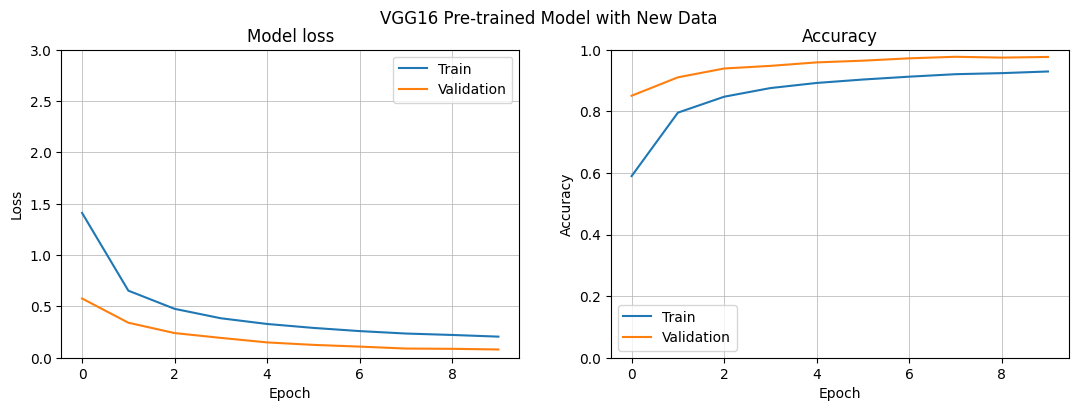

In [38]:
plot_loss_accuracy(history_vgg16, 'VGG16 Pre-trained Model with New Data')

In [39]:
letters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13,
            'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,
            'space':26, 'del':27, 'nothing':28}
root_directory = "raw_data/asl_alphabet_test"  # Replace with the root directory path
image_test_paths = []
labels_test = []

for f in os.listdir(root_directory):
    if f.endswith('.jpg'): 
        image_test_paths.append(os.path.join(root_directory, f))
        labels_test.append(str(letters[f.split('_')[0]]))

# Create a DataFrame from the collected data
image_test = {
    'Image_Path': image_test_paths,
    'Label': labels_test}

df_test = pd.DataFrame(image_test)
# Print the DataFrame
print(df_test)

                                     Image_Path Label
0         raw_data/asl_alphabet_test/J_test.jpg     9
1         raw_data/asl_alphabet_test/B_test.jpg     1
2         raw_data/asl_alphabet_test/F_test.jpg     5
3         raw_data/asl_alphabet_test/L_test.jpg    11
4         raw_data/asl_alphabet_test/U_test.jpg    20
5     raw_data/asl_alphabet_test/space_test.jpg    26
6         raw_data/asl_alphabet_test/N_test.jpg    13
7         raw_data/asl_alphabet_test/K_test.jpg    10
8         raw_data/asl_alphabet_test/Z_test.jpg    25
9         raw_data/asl_alphabet_test/X_test.jpg    23
10        raw_data/asl_alphabet_test/C_test.jpg     2
11        raw_data/asl_alphabet_test/Q_test.jpg    16
12        raw_data/asl_alphabet_test/M_test.jpg    12
13        raw_data/asl_alphabet_test/T_test.jpg    19
14        raw_data/asl_alphabet_test/Y_test.jpg    24
15        raw_data/asl_alphabet_test/O_test.jpg    14
16        raw_data/asl_alphabet_test/W_test.jpg    22
17        raw_data/asl_alpha

In [40]:
def load_test_dataset_labeled(df, image_size, batch_size):
    # Create a data generator
    datagen = tflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Load the image dataset
    image_generator = datagen.flow_from_dataframe(
                        dataframe=df,
                        x_col=df.columns[0],
                        y_col=df.columns[1],
                        target_size=image_size,
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=False)  # Disable shuffling for the test dataset
    
    return image_generator

test_data = load_test_dataset_labeled(df_test, (50,50), 32)

Found 28 validated image filenames belonging to 28 classes.


In [6]:
test_data.__dict__

{'image_data_generator': <keras.preprocessing.image.ImageDataGenerator at 0x7f56dc092d60>,
 'target_size': (50, 50),
 'keep_aspect_ratio': False,
 'color_mode': 'rgb',
 'data_format': 'channels_last',
 'image_shape': (50, 50, 3),
 'save_to_dir': None,
 'save_prefix': '',
 'save_format': 'png',
 'interpolation': 'nearest',
 'split': None,
 'subset': None,
 'directory': '',
 'class_mode': 'categorical',
 'dtype': 'float32',
 'class_indices': {'0': 0,
  '1': 1,
  '10': 2,
  '11': 3,
  '12': 4,
  '13': 5,
  '14': 6,
  '15': 7,
  '16': 8,
  '17': 9,
  '18': 10,
  '19': 11,
  '2': 12,
  '20': 13,
  '21': 14,
  '22': 15,
  '23': 16,
  '24': 17,
  '25': 18,
  '26': 19,
  '28': 20,
  '3': 21,
  '4': 22,
  '5': 23,
  '6': 24,
  '7': 25,
  '8': 26,
  '9': 27},
 'classes': [27,
  1,
  23,
  3,
  13,
  19,
  5,
  2,
  18,
  16,
  12,
  8,
  4,
  11,
  17,
  6,
  15,
  22,
  24,
  0,
  21,
  10,
  9,
  26,
  14,
  25,
  20,
  7],
 'filenames': ['raw_data/asl_alphabet_test/J_test.jpg',
  'raw_data/as

In [41]:
test_images, test_labels = next(test_data)
# `images` is a batch of images
# `labels` is a batch of corresponding labels
print("Image shape:", test_images.shape, type(test_images))
print("Label shape:", test_labels.shape, type(test_labels))

X_test = test_images
y_test = np.hstack((test_labels, np.zeros((28)).reshape(-1,1)))

print(test_labels[0])
print(y_test[0])
X_test.shape, y_test.shape

Image shape: (28, 50, 50, 3) <class 'numpy.ndarray'>
Label shape: (28, 28) <class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0.]


((28, 50, 50, 3), (28, 29))

In [45]:

# Load the trained model
# model = load_model('path/to/trained_model.h5')

# Evaluate the model on the test dataset
loss, accuracy = model_vgg16.evaluate(X_test, y_test)

print(f'VGG16 Test loss: {loss:.4f}')
print(f'VGG16 Test accuracy: {accuracy:.4f}')

1/1 [==============================] - 0s 272ms/step - loss: 7.5020 - accuracy: 0.7143
VGG16 Test loss: 7.5020
VGG16 Test accuracy: 0.7143


In [46]:
models.save_model(model_vgg16, "transfer_models/model_vgg16_v2")

2023-05-24 22:56:09.063831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-24 22:56:09.891615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: transfer_models/model_vgg16_v2/assets


INFO:tensorflow:Assets written to: transfer_models/model_vgg16_v2/assets


In [47]:
def initialize_model_resn50(image_width, image_height, no_chans, n_classes):
    #Initialising ResNet50 
    classifier_resnet = tflow.keras.applications.ResNet50(input_shape= (image_width,image_height,no_chans),include_top=False,weights='imagenet')
    
    #don't train existing weights for resnet50
    for layer in classifier_resnet.layers:
        layer.trainable = False
     
    #Add the necessary layers for pre-trained model   
    classifier = classifier_resnet.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=512, activation='relu')(classifier)
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dense(units=128, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(units=n_classes, activation='softmax')(classifier)

    #Build and compile the model
    model = Model(inputs = classifier_resnet.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [48]:
es = EarlyStopping(patience=5, restore_best_weights=True)

steps_per_epoch = train_data_50.n // batch_size
epochs = 20
print(steps_per_epoch)

model_resn50 = initialize_model_resn50(50,50,3,29)

history_vgg16 = model_resn50.fit(
                    train_data_50,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_50,
                    callbacks=[es],
                    verbose=1)

1903
Epoch 1/20


2023-05-24 22:58:34.767419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1903/1903 [==============================] - ETA: 0s - loss: 2.6022 - accuracy: 0.2081

2023-05-24 23:06:46.599285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1903/1903 [==============================] - 642s 335ms/step - loss: 2.6022 - accuracy: 0.2081 - val_loss: 2.0750 - val_accuracy: 0.3131
Epoch 2/20
1903/1903 [==============================] - 613s 322ms/step - loss: 1.8860 - accuracy: 0.3865 - val_loss: 1.6565 - val_accuracy: 0.4511
Epoch 3/20
1903/1903 [==============================] - 627s 330ms/step - loss: 1.5627 - accuracy: 0.4818 - val_loss: 1.5044 - val_accuracy: 0.4973
Epoch 4/20
1903/1903 [==============================] - 608s 320ms/step - loss: 1.3684 - accuracy: 0.5429 - val_loss: 1.3010 - val_accuracy: 0.5596
Epoch 5/20
1903/1903 [==============================] - 555s 292ms/step - loss: 1.2437 - accuracy: 0.5828 - val_loss: 1.1283 - val_accuracy: 0.6281
Epoch 6/20
1903/1903 [==============================] - 543s 285ms/step - loss: 1.1402 - accuracy: 0.6163 - val_loss: 1.0385 - val_accuracy: 0.6507
Epoch 7/20
1903/1903 [==============================] - 558s 293ms/step - loss: 1.0656 - accuracy: 0.6382 - val_loss: 1.006

In [49]:
models.save_model(model_resn50, "transfer_models/model_resnet50_v1")

2023-05-25 03:13:51.551612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-25 03:13:59.749515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: transfer_models/model_resnet50_v1/assets


INFO:tensorflow:Assets written to: transfer_models/model_resnet50_v1/assets


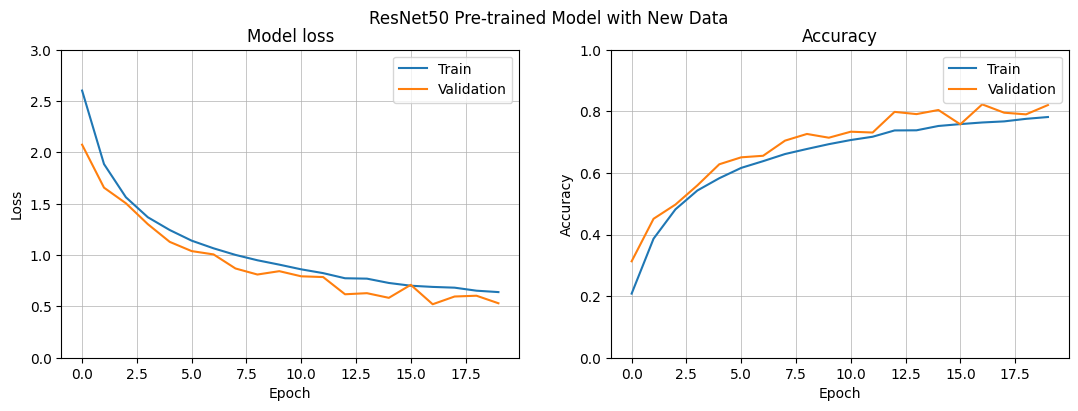

In [50]:
plot_loss_accuracy(history_vgg16, 'ResNet50 Pre-trained Model with New Data')

In [51]:
# Load the trained model
# model = load_model('path/to/trained_model.h5')

# Evaluate the model on the test dataset
loss, accuracy = model_resn50.evaluate(X_test, y_test)

print(f'ResNet50 Test loss: {loss:.4f}')
print(f'ResNet50 Test accuracy: {accuracy:.4f}')

1/1 [==============================] - 0s 209ms/step - loss: 11.5385 - accuracy: 0.6071
ResNet50 Test loss: 11.5385
ResNet50 Test accuracy: 0.6071
